# Homework 2: Linear Models for Regression and Classification

Due 10/21 at 11:59pm

In this notebook, we will be implementing three linear models: linear regression, logistic regression, and SVM. We will see that despite some of their differences at the surface, these linear models (and many machine learning models in general) are fundamentally doing the same thing - that is, optimizing model parameters to minimize a loss function on data.

**Note: There are two notebooks in Homework 2. Please also complete the other notebook `HW2_Decision_Trees.ipynb` for full credit on this assignment.**

![comic](https://pbs.twimg.com/media/ESlslPWWkAAcNP-?format=jpg&name=900x900)

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import LinearSVC
import seaborn as sns

## Part 1: Linear Regression

### 1.1 Data Exploration

In part 1, we will use two datasets to train and evaluate our linear regression model. 

The first dataset will be a synthetic dataset sampled from the following equations:

$$
\epsilon \sim \text{Normal}(0, 3) \\
y = 3x + 10 + \epsilon
$$

In [52]:
np.random.seed(0)
epsilon = np.random.normal(0, 3, 100)   # Sample epsilon from a Normal distribution
x = np.linspace(0, 10, 100)             # Sample x evenly between 0 and 100
y = 3 * x + 10 + epsilon

Note that the above dataset satisfies all the assumptions of a linear regression model:
- Linearity: $y$ is a linear (technically affine) function of $x$.
- Independence: the $x$'s are independently drawn, and not dependent on each other.
- Homoscedasticity: the $\epsilon$'s, and thus the $y$'s, have constant variance.
- Normality: the $\epsilon$'s are drawn from a Normal distribution (i.e. Normally-distributed errors)

These properties, as well as the simplicity of this dataset, will make it a good test case to check if our linear regression model is working properly.

**Plot y vs x in the synthetic dataset as a scatter plot. Label your axes and make sure your y-axis starts from 0.**

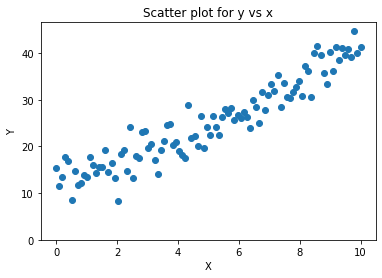

In [53]:
### Your code here
plt.scatter(x, y)
plt.ylim(ymin = 0)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter plot for y vs x")
plt.show()

The second dataset we will be using is an [auto MPG dataset](https://archive.ics.uci.edu/ml/datasets/Auto+MPG). This dataset contains various characteristics for around 400 cars. We will use linear regression to predict the mpg label from seven features (4 continuous, 3 discrete).

In [54]:
# Load auto MPG dataset
auto_mpg_df = pd.read_csv('auto-mpg.csv')

# drop some rows with missing entries
auto_mpg_df = auto_mpg_df[auto_mpg_df['horsepower'] != '?']

# Cast horsepower column to float
auto_mpg_df['horsepower'] = auto_mpg_df['horsepower'].astype(float)

auto_mpg_df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [55]:
# Split data into features and labels
auto_mpg_X = auto_mpg_df.drop(columns = ['mpg'])
auto_mpg_y = auto_mpg_df['mpg']

**Plot the distribution of the label (mpg) using a histogram.**

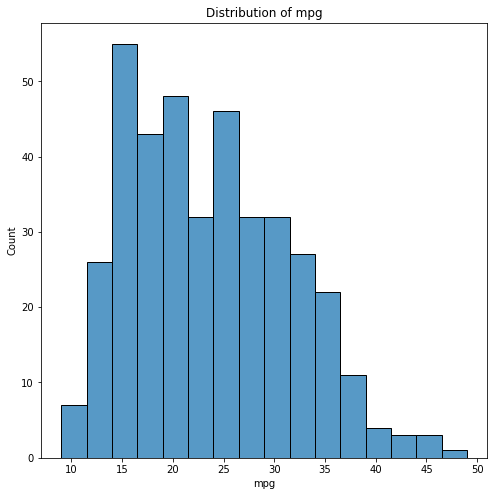

In [56]:
### Your code here
plt.figure(figsize = (8,8))
sns.histplot(auto_mpg_y, binwidth = 2.5)
plt.xlabel('mpg')
plt.ylabel('Count')
plt.title('Distribution of mpg')
plt.show()

**Plot the relationships between the label (mpg) and the continuous features (displacement, horsepower, weight, acceleration) using a small multiple of scatter plots. Make sure to label the axes.**

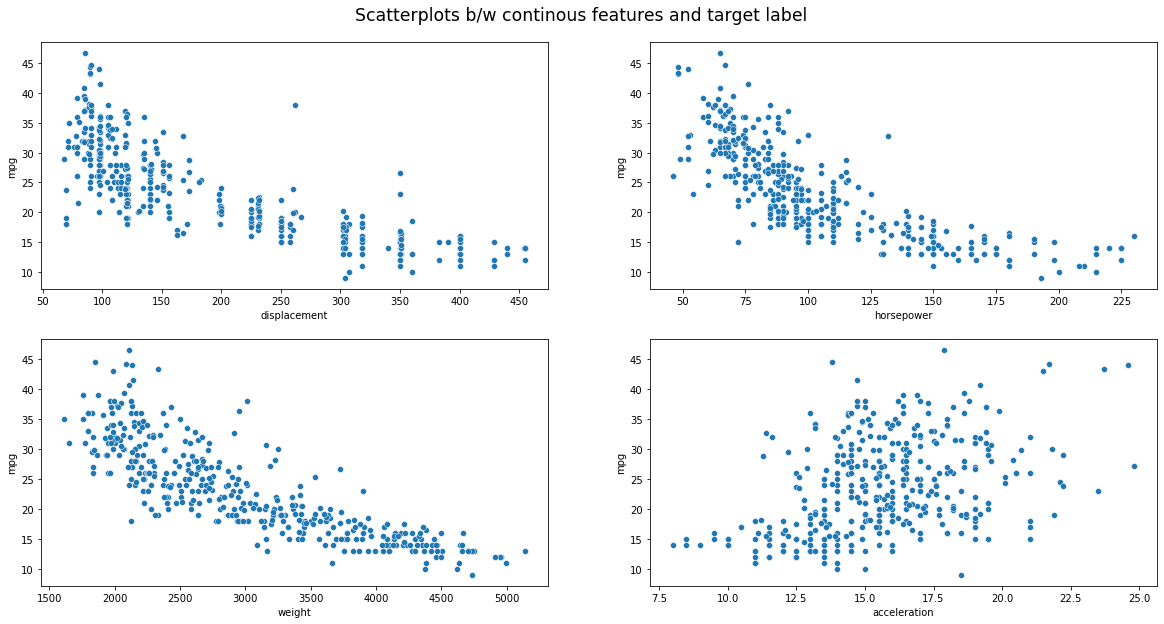

In [57]:
### Your code here
num_features = ['displacement', 'horsepower', 'weight', 'acceleration']
fig, axes = plt.subplots(2,2,figsize = (20,10))
fig.suptitle("Scatterplots b/w continous features and target label", y = 0.93, size = "xx-large")
for var, subplot in zip(num_features, axes.flatten()):
    sns.scatterplot(x = var, y = auto_mpg_y, data = auto_mpg_X, ax = subplot)

**Plot the relationships between the label (mpg) and the discrete features (cylinders, model year, origin) using a small multiple of box plots. Make sure to label the axes.**

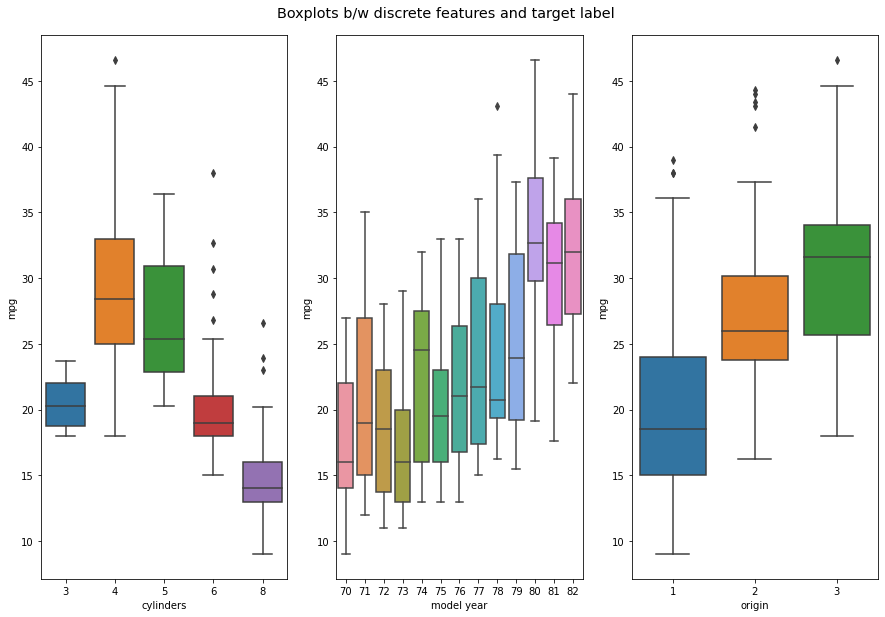

In [58]:
### Your code here
discrete_features = ['cylinders', 'model year', 'origin']
fig, axes = plt.subplots(1,3,figsize = (15,10))
fig.suptitle("Boxplots b/w discrete features and target label", x = 0.5, y = 0.92, size = "x-large")
for var, subplot in zip(discrete_features, axes.flatten()):
    sns.boxplot(x = var, y = auto_mpg_y, data = auto_mpg_X, ax = subplot)

**From the visualizations above, do you think linear regression is a good model for this problem? Why and/or why not?**

### Your answer here

Upon examining the scatter plots, we can see a linear relationship between mpg and all the continuous variables. The nature of the correlation is negative for displacement, horsepower and weight and somewhat positive for acceleration.  Even the categorical variables show linear trends like in model year and origin where there is a positive relation with mpg. Cylinders does not follow a very obvious linear relationship but in general more the cylinders, lesser the mpg value. Therefore linear regression can be a good fit for this problem.

### 1.2 Data Pre-processing

Before we can fit a linear regression model, there are several pre-processing steps we should apply to the datasets:
1. Encode categorial features appropriately.
2. Split the dataset into training (60%), validation (20%), and test (20%) sets.
3. Standardize the columns in the feature matrices X_train, X_val, and X_test to have zero mean and unit variance. To avoid information leakage, learn the standardization parameters (mean, variance) from X_train, and apply it to X_train, X_val, and X_test.
4. Add a column of ones to the feature matrices X_train, X_val, and X_test. This is a common trick so that we can learn a coefficient for the bias term of a linear model.

The processing steps on the synthetic dataset have been provided for you below as a reference:

In [59]:
X = x.reshape((100, 1))   # Turn the x vector into a feature matrix X

# 1. No categorical features in the synthetic dataset (skip this step)

# 2. Split the dataset into training (60%), validation (20%), and test (20%) sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.25, random_state = 0)

# 3. Standardize the columns in the feature matrices
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # Fit and transform scalar on X_train
X_val = scaler.transform(X_val)           # Transform X_val
X_test = scaler.transform(X_test)         # Transform X_test

# 4. Add a column of ones to the feature matrices
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

print(X_train[:5], '\n\n', y_train[:5])

[[ 1.          0.53651502]
 [ 1.         -1.00836082]
 [ 1.         -0.72094206]
 [ 1.         -0.25388657]
 [ 1.          0.64429705]] 

 [25.10940496 14.74320191 20.52842695 21.80437679 31.0649271 ]


In [60]:
# Verify that columns (other than the ones column) have 0 mean, 1 variance
print(X_train.mean(axis = 0), X_train.std(axis = 0))
print(X_val.mean(axis = 0), X_val.std(axis = 0))
print(X_test.mean(axis = 0), X_test.std(axis = 0))

[ 1.00000000e+00 -4.81096644e-17] [0. 1.]
[ 1.        -0.1263445] [0.         1.03471221]
[ 1.         -0.15508637] [0.         1.13264481]


In [61]:
# Split data into features and labels
auto_mpg_X = auto_mpg_df.drop(columns=['mpg'])
auto_mpg_y = auto_mpg_df['mpg']

**Now, apply the same processing steps on the auto MPG dataset.**

In [62]:
### Your code here

#1. Categorical features in the synthetic dataset

discrete_features = ['cylinders', 'model year', 'origin']
auto_mpg_X = pd.get_dummies(auto_mpg_X, columns = discrete_features)

# 2. Split the dataset into training (60%), validation (20%), and test (20%) sets

X_dev, auto_mpg_X_test, y_dev, auto_mpg_y_test = train_test_split(auto_mpg_X,
                                                                  auto_mpg_y,
                                                                  test_size = 0.2,
                                                                  random_state = 0)

auto_mpg_X_train, auto_mpg_X_val, auto_mpg_y_train, auto_mpg_y_val = train_test_split(X_dev,
                                                                                      y_dev,
                                                                                      test_size = 0.25,
                                                                                      random_state = 0)

# 3. Standardize the columns in the feature matrices

scaler = StandardScaler()
auto_mpg_X_train = scaler.fit_transform(auto_mpg_X_train)   # Fit and transform scalar on X_train
auto_mpg_X_val = scaler.transform(auto_mpg_X_val)           # Transform X_val
auto_mpg_X_test = scaler.transform(auto_mpg_X_test)         # Transform X_test

auto_mpg_X_train = np.hstack([np.ones((auto_mpg_X_train.shape[0], 1)), auto_mpg_X_train])
auto_mpg_X_val = np.hstack([np.ones((auto_mpg_X_val.shape[0], 1)), auto_mpg_X_val])
auto_mpg_X_test = np.hstack([np.ones((auto_mpg_X_test.shape[0], 1)), auto_mpg_X_test])

At the end of this pre-processing, you should have the following vectors and matrices: 
- Syntheic dataset: X_train, X_val, X_test, y_train, y_val, y_test
- Auto MPG dataset: auto_mpg_X_train, auto_mpg_X_val, auto_mpg_X_test, auto_mpg_y_train, auto_mpg_y_val, auto_mpg_y_test

### 1.3 Implement Linear Regression

Now, we can implement our linear regression model! Specifically, we will be implementing ridge regression, which is linear regression with L2 regularization. Given an (m x n) feature matrix $X$, an (m x 1) label vector $y$, and an (n x 1) weight vector $w$, the hypothesis function for linear regression is:

$$
y = X w
$$

Note that we can omit the bias term here because we have included a column of ones in our $X$ matrix, so the bias term is learned implicitly as a part of $w$. This will make our implementation easier.

Our objective in linear regression is to learn the weights $w$ which best fit the data. This notion can be formalized as finding the optimal $w$ which minimizes the following loss function:

$$
\min_{w} \| X w - y \|^2_2 + \alpha \| w \|^2_2 \\
$$

This is the ridge regression loss function. The $\| X w - y \|^2_2$ term penalizes predictions $Xw$ which are not close to the label $y$. And the $\alpha \| w \|^2_2$ penalizes large weight values, to favor a simpler, more generalizable model. The $\alpha$ hyperparameter, known as the regularization parameter, is used to tune the complexity of the model - a higher $\alpha$ results in smaller weights and lower complexity, and vice versa. Setting $\alpha = 0$ gives us vanilla linear regression.

Conveniently, ridge regression has a closed-form solution which gives us the optimal $w$ without having to do iterative methods such as gradient descent. The closed-form solution, known as the Normal Equations, is given by:

$$
w = (X^T X + \alpha I)^{-1} X^T y
$$

**Implement a `LinearRegression` class with two methods: `train` and `predict`.** You may NOT use sklearn for this implementation. You may, however, use `np.linalg.solve` to find the closed-form solution. It is highly recommended that you vectorize your code.

In [63]:
class LinearRegression():
    '''
    Linear regression model with L2-regularization (i.e. ridge regression).

    Attributes
    ----------
    alpha: regularization parameter
    w: (n x 1) weight vector
    '''
    
    def __init__(self, alpha=0):
        self.alpha = alpha
        self.w = None

    def train(self, X, y):
        '''Trains model using ridge regression closed-form solution 
        (sets w to its optimal value).
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        None
        '''
        ### Your code here
        alpha = self.alpha
        A = np.dot(np.transpose(X), X) + alpha*np.eye(X.shape[1])
        B = np.dot(np.transpose(X), y)
        w = np.linalg.solve(A,B)
        self.w = w
        return self
    
    def predict(self, X):
        '''Predicts on X using trained model.
        
        Parameters
        ----------
        X : (m x n) feature matrix
        
        Returns
        -------
        y_pred: (m x 1) prediction vector
        '''
        ### Your code here
        y_pred = np.dot(X, self.w)
        return y_pred

### 1.4 Train,  Evaluate, and Interpret Linear Regression Model

**Using your `LinearRegression` implementation above, train a vanilla linear regression model ($\alpha = 0$) on (X_train, y_train) from the synthetic dataset. Use this trained model to predict on X_test. Report the first 5 predictions on X_test, along with the actual labels in y_test.**

In [64]:
### Your code here
model=LinearRegression(alpha=0)
model.train(X_train,y_train)
prediction=model.predict(X_test)
print('The MSE for the model is',np.square(np.subtract(y_test,prediction)).mean())
print("First 5 predictions: ", y_test[0:5])
print("First 5 actual labels: ", prediction[0:5])

The MSE for the model is 8.790279666259424
First 5 predictions:  [18.01606343 39.59694477 13.54227456 27.95166228 30.67284245]
First 5 actual labels:  [18.04431976 35.63981279 11.00612254 26.54880806 32.4139724 ]


**Plot a scatter plot of y_test vs X_test (just the non-ones column). Then, using the weights from the trained model above, plot the best-fit line for this data on the same figure.** If your line goes through the data points, you have likely implemented the linear regression correctly!

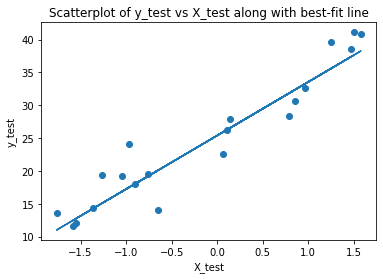

In [65]:
### Your code here
plt.scatter(X_test[:,1], y_test)
plt.plot(X_test[:,1],prediction)
plt.title("Scatterplot of y_test vs X_test along with best-fit line")
plt.xlabel("X_test")
plt.ylabel("y_test")
plt.show()

**Train a linear regression model ($\alpha = 0$) on the auto MPG training data. Make predictions and report the mean-squared error (MSE) on the training, validation, and test sets. Report the first 5 predictions on the test set, along with the actual labels.**

In [66]:
### Your code here
model_mpg = LinearRegression(alpha = 0)
model_mpg.train(auto_mpg_X_train, auto_mpg_y_train)

Y_pred_train = model_mpg.predict(auto_mpg_X_train)
print("MSE (training set): ", np.square(np.subtract(auto_mpg_y_train, Y_pred_train)).mean())

Y_pred_val = model_mpg.predict(auto_mpg_X_val)
print("MSE (validation set): ", np.square(np.subtract(auto_mpg_y_val, Y_pred_val)).mean())

Y_pred_test = model_mpg.predict(auto_mpg_X_test)
print("MSE (test set): ", np.square(np.subtract(auto_mpg_y_test, Y_pred_test)).mean())

print("First 5 predictions on test set:")
print(Y_pred_test[:5])
print("First 5 actual labels on test set:")
print(np.array(auto_mpg_y_test[:5]))

MSE (training set):  7.299621745436066
MSE (validation set):  9.973981450079519
MSE (test set):  8.686778044000008
First 5 predictions on test set:
[27.01421931 26.90758001 11.01159079 33.37090115 36.13065395]
First 5 actual labels on test set:
[28.  22.3 12.  38.  33.8]


**As a baseline model, use the mean of the training labels (auto_mpg_y_train) as the prediction for all instances. Report the mean-squared error (MSE) on the training, validation, and test sets using this baseline.** This is a common baseline used in regression problems and tells you if your model is any good. Your linear regression MSEs should be much lower than these baseline MSEs.

In [67]:
### Your code here
mean = auto_mpg_y_train.mean()
print("Baseline MSE (training set): ",np.square(np.subtract(auto_mpg_y_train,mean)).mean())
print("Baseline MSE (validation set): ",np.square(np.subtract(auto_mpg_y_val,mean)).mean())
print("Baseline MSE (test set): ",np.square(np.subtract(auto_mpg_y_test,mean)).mean())

Baseline MSE (training set):  60.564614654101774
Baseline MSE (validation set):  60.47988929483246
Baseline MSE (test set):  62.46160518794081


**Interpret your model trained on the auto MPG dataset using a bar chart of the model weights.** Make sure to label the bars (x-axis) and don't forget the bias term! Use lecture 3, slide 15 as a reference.

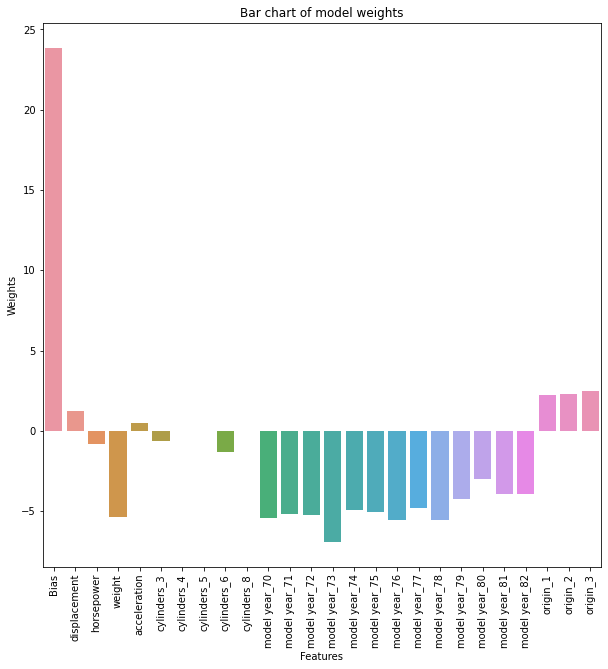

In [68]:
### Your code here
fig=plt.figure(figsize=(10,10))
ones= np.eye(auto_mpg_X_train.shape[1])
ax=sns.barplot(x=['Bias']+list(X_dev.columns),y=model_mpg.w)
ax.tick_params(axis='x',rotation=90)
ax.set_xlabel('Features')
ax.set_ylabel('Weights')
ax.set_title('Bar chart of model weights')
plt.show()

**According to your model, which features are the greatest contributors to the MPG?**

### Your answer here

The greatest contributing features are model year features (encoded), weight and origin (encoded). This is evident from the above graph. Both weight and model year have higher magnitude negative weights while origin had larger positive weights. 

### 1.5 Tune Regularization Parameter $\alpha$

Now, let's do ridge regression and tune the $\alpha$ regularization parameter on the auto MPG dataset.

**Sweep out values for $\alpha$ using `alphas = np.logspace(-2, 1, 10)`. Perform a grid search over these $\alpha$ values, recording the training and validation MSEs for each $\alpha$. A simple grid search is fine, no need for k-fold cross validation. Plot the training and validation MSEs as a function of $\alpha$ on a single figure. Make sure to label the axes and the training and validation MSE curves. Use a log scale for the x-axis.**

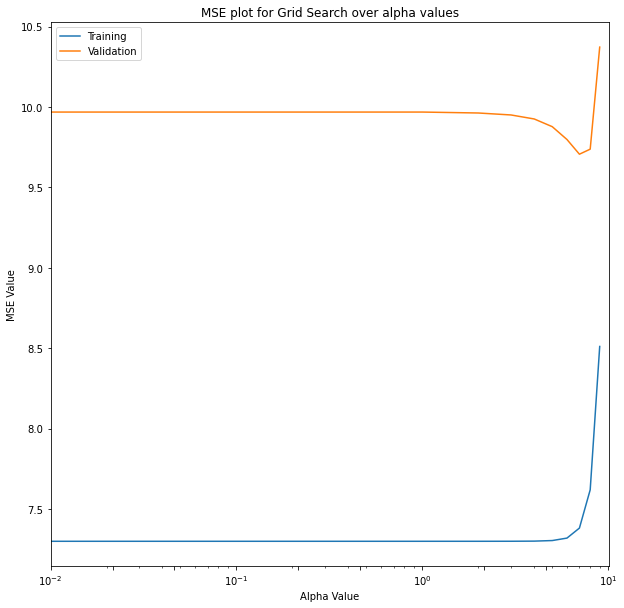

In [69]:
### Your code here
alphas = np.logspace(-2, 1, 10)
mse_train = []
mse_val = []
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)
for i in alphas:
    model_mpg = LinearRegression(alpha = i)
    model_mpg.train(auto_mpg_X_train, auto_mpg_y_train)
    Y_pred_train = model_mpg.predict(auto_mpg_X_train)
    mse_train.append(np.square(np.subtract(auto_mpg_y_train, Y_pred_train)).mean())
    Y_pred_val = model_mpg.predict(auto_mpg_X_val)
    mse_val.append(np.square(np.subtract(auto_mpg_y_val, Y_pred_val)).mean())
ax.plot(mse_train, label='Training')
ax.plot(mse_val, label='Validation')
ax.set_xscale('log')
ax.set_xlabel("Alpha Value")
ax.set_ylabel("MSE Value")
plt.xticks(alphas)
plt.legend()
plt.title("MSE plot for Grid Search over alpha values")
plt.show()

In [74]:
dff = pd.DataFrame()
dff['mse_val']=mse_val
dff['mse_train']=mse_train
dff['alphas']=alphas
print(dff)

     mse_val  mse_train     alphas
0   9.971600   7.299624   0.010000
1   9.968870   7.299632   0.021544
2   9.963056   7.299671   0.046416
3   9.950834   7.299846   0.100000
4   9.925874   7.300647   0.215443
5   9.877982   7.304216   0.464159
6   9.798166   7.319550   1.000000
7   9.706790   7.381771   2.154435
8   9.738179   7.619790   4.641589
9  10.372782   8.511101  10.000000


**Explain your plot above. How do training and validation MSE behave with decreasing model complexity (increasing $\alpha$)?**

### Your answer here

With a reduction in model complexity, training MSE starts to rise near alpha = 2.154435. However validation MSE fell at this point which suggests overfitting was overcome with lower model complexity. The optimum value for alpha is 2.154435. Post this optimum value of alpha val error starts to rise again suggesting underfitting. Training scores and validation scores remain more or less constant until alpha=2.154435.

**Using the $\alpha$ which gave the best validation MSE above, train a model on the training set. Report the value of $\alpha$ and its training, validation, and test MSE.** This is the final tuned model which you would deploy in production.

In [75]:
### Your code here
best_alpha = alphas[np.argmin(mse_val)]
print("Best alpha value:", best_alpha)

best_model_mpg = LinearRegression(alpha = best_alpha)
best_model_mpg.train(auto_mpg_X_train, auto_mpg_y_train)

Y_pred_train = best_model_mpg.predict(auto_mpg_X_train)
print("MSE (training set): ", np.square(np.subtract(auto_mpg_y_train, Y_pred_train)).mean())

Y_pred_val = best_model_mpg.predict(auto_mpg_X_val)
print("MSE (validation set): ", np.square(np.subtract(auto_mpg_y_val, Y_pred_val)).mean())

Y_pred_test = best_model_mpg.predict(auto_mpg_X_test)
print("MSE (test set): ", np.square(np.subtract(auto_mpg_y_test, Y_pred_test)).mean())

Best alpha value: 2.154434690031882
MSE (training set):  7.38177069089372
MSE (validation set):  9.70679036638384
MSE (test set):  8.498442133321921


## Part 2: Logistic Regression

### 2.1 Data Exploration

<img src="https://pathology.jhu.edu/build/assets/breast/_image1200/368/ILC.jpg" alt="cells" width="400"/>

In parts 2 and 3, we will be using a [breast cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) for classification. Given 30 continuous features describing the nuclei of cells in a digitized image of a [fine needle aspirate (FNA)](https://www.cancer.org/cancer/breast-cancer/screening-tests-and-early-detection/breast-biopsy/fine-needle-aspiration-biopsy-of-the-breast.html) of a breast mass, we will train logistic regression and SVM models to classify each sample as benign (B) or malignant (M).

In [84]:
cancer_df = pd.read_csv('breast-cancer.csv')
cancer_df = cancer_df.drop(columns=['id', 'Unnamed: 32'])
cancer_df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [85]:
# Split data into features and labels
cancer_X = cancer_df.drop(columns=['diagnosis'])
cancer_y = cancer_df['diagnosis']

**Compute the distribution of the labels. What is the probability of observing the majority class?** This is a common baseline for accuracy in classification problems.

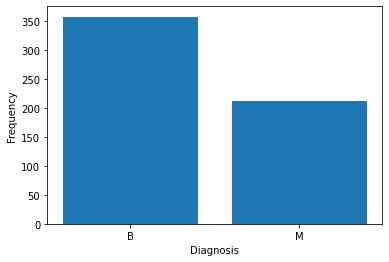

In [86]:
### Your code here
categories = cancer_y.value_counts().index
counts = cancer_y.value_counts().values
plt.bar(categories, counts)
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.show()

In [87]:
### Your code here
label_dist = cancer_y.value_counts()
print(label_dist)
prob = label_dist[0]/(label_dist[0]+label_dist[1])
print("Probability of observing the majority class: ", prob*100, "%")

B    357
M    212
Name: diagnosis, dtype: int64
Probability of observing the majority class:  62.741652021089635 %


**Plot the relationships between the label (diagnosis) and the 30 features using a small multiple of box plots. Make sure to label the axes.**

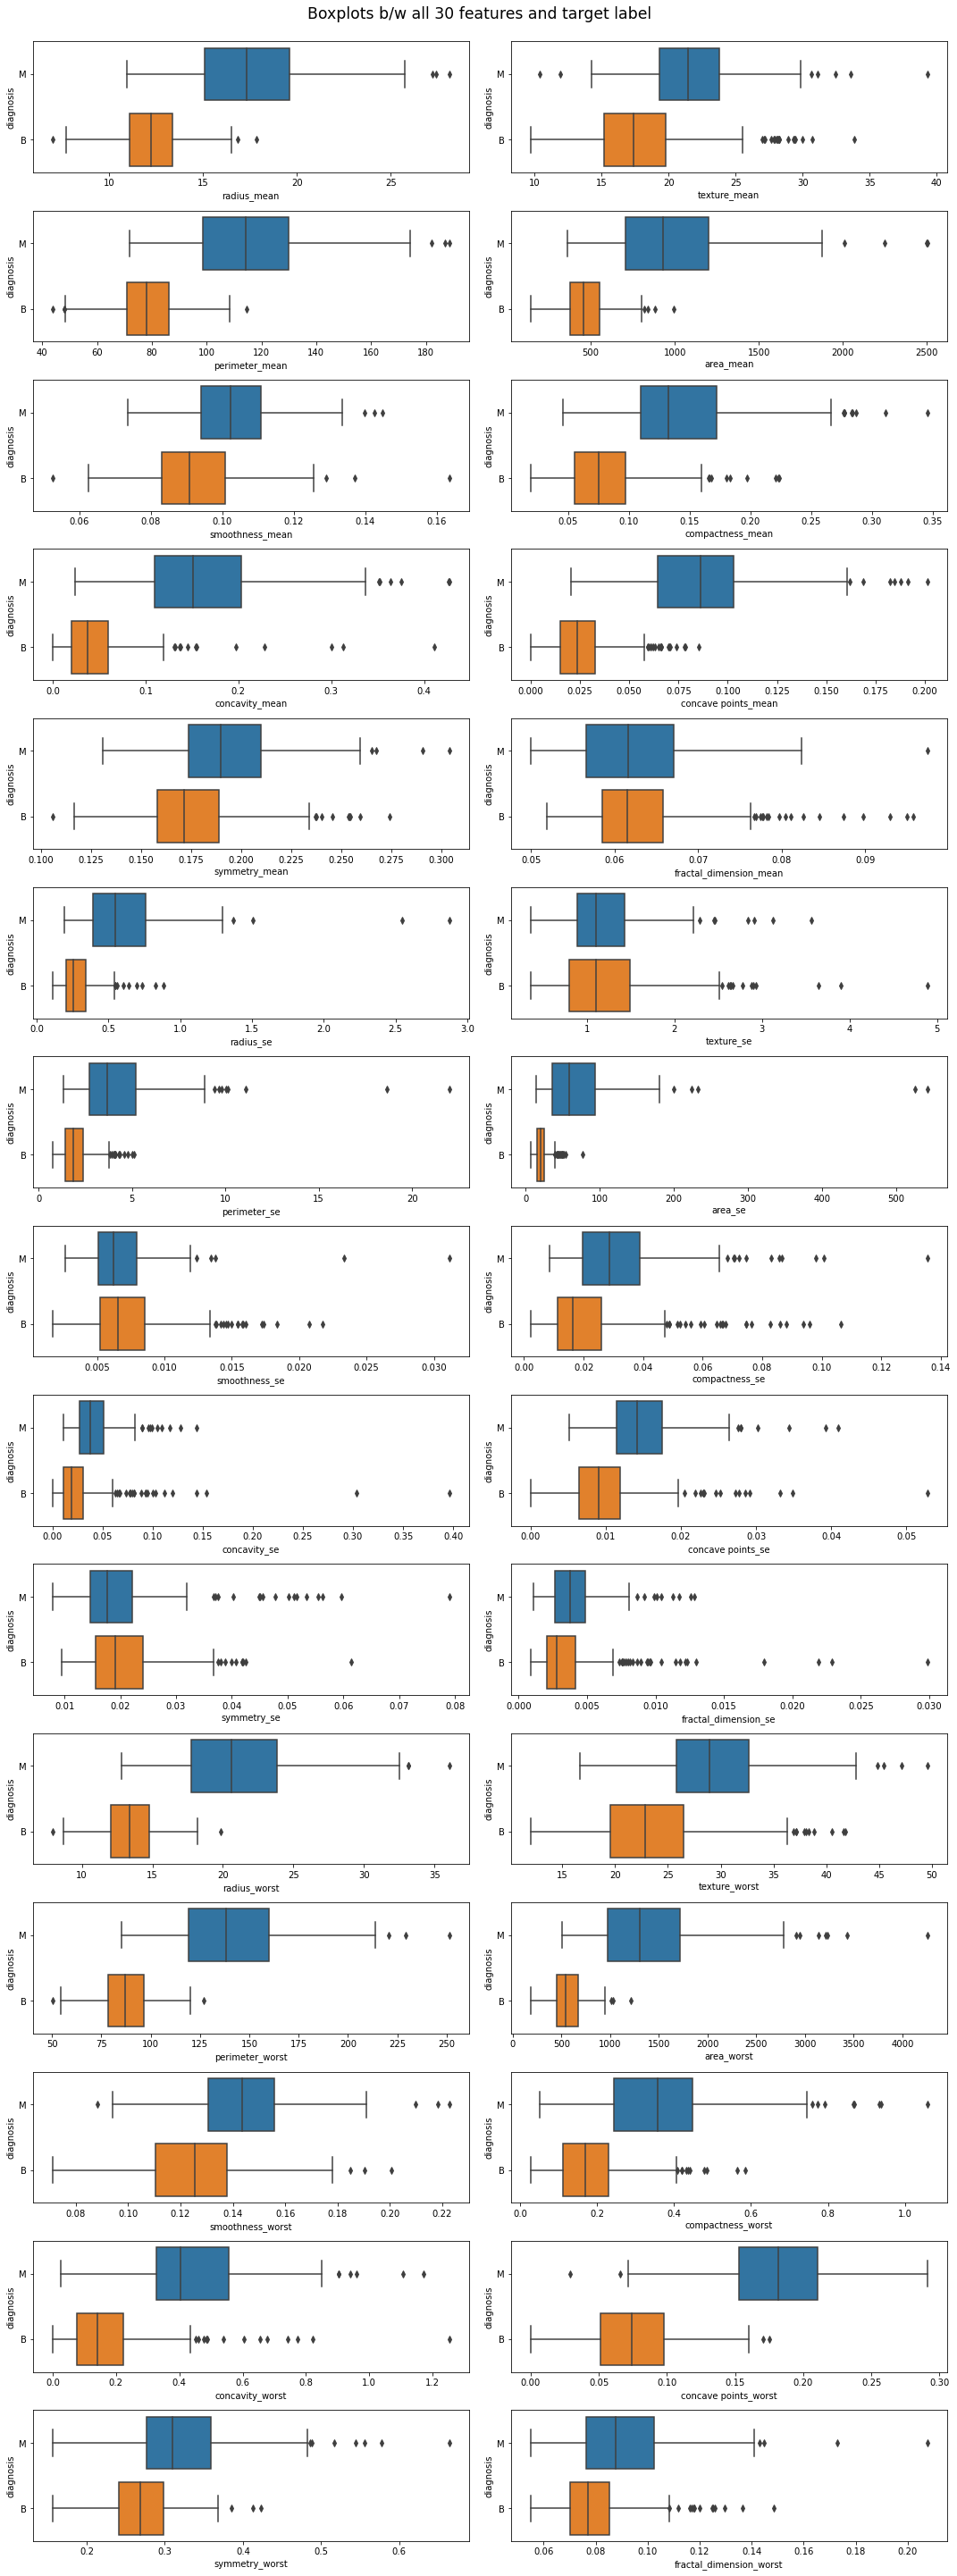

In [88]:
### Your code here
fig, axes = plt.subplots(15, 2, figsize = (15, 40))
fig.suptitle("Boxplots b/w all 30 features and target label", y = 1, size = 'xx-large')
for var, subplot in zip(cancer_X.columns, axes.flatten()):
    sns.boxplot(x = var, y = cancer_y, data = cancer_X, ax = subplot)
plt.tight_layout()
plt.show()

### 2.2 Data Pre-processing

**Apply the following pre-processing steps to the breast cancer dataset:**

1. Encode the categorical label as 0 (B) or 1 (M).
2. Convert the label from a Pandas series to a Numpy (m x 1) vector. If you don't do this, it may cause problems when implementing the logistic regression model (certain broadcasting operations may fail unexpectedly).
2. Split the dataset into training (60%), validation (20%), and test (20%) sets.
3. Standardize the columns in the feature matrices cancer_X_train, cancer_X_val, and cancer_X_test to have zero mean and unit variance. To avoid information leakage, learn the standardization parameters (mean, variance) from cancer_X_train, and apply it to cancer_X_train, cancer_X_val, and cancer_X_test.
4. Add a column of ones to the feature matrices cancer_X_train, cancer_X_val, and cancer_X_test. This is a common trick so that we can learn a coefficient for the bias term of a linear model.


In [89]:
### Your code here
cancer_y = np.where(cancer_y.str.contains("B"), 0, 1)
X_dev, cancer_X_test, y_dev, cancer_y_test = train_test_split(cancer_X, cancer_y, test_size=0.2, random_state=0)
cancer_X_train, cancer_X_val, cancer_y_train, cancer_y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0)

# 3. Standardize the columns in the feature matrices
scaler = StandardScaler()
cancer_X_train = scaler.fit_transform(cancer_X_train)   # Fit and transform scalar on X_train
cancer_X_val = scaler.transform(cancer_X_val)           # Transform X_val
cancer_X_test = scaler.transform(cancer_X_test)  

cancer_X_train = np.hstack([np.ones((cancer_X_train.shape[0], 1)), cancer_X_train])
cancer_X_val = np.hstack([np.ones((cancer_X_val.shape[0], 1)), cancer_X_val])
cancer_X_test = np.hstack([np.ones((cancer_X_test.shape[0], 1)), cancer_X_test])

At the end of this pre-processing, you should have the following vectors and matrices: cancer_X_train, cancer_X_val, cancer_X_test, cancer_y_train, cancer_y_val, cancer_y_test.

### 2.3 Implement Logistic Regression

We will now implement logistic regression with L2 regularization. Given an (m x n) feature matrix $X$, an (m x 1) label vector $y$, and an (n x 1) weight vector $w$, the hypothesis function for logistic regression is:

$$
y = \sigma(X w)
$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$, i.e. the sigmoid function. This function scales the prediction to be a probability between 0 and 1, and can then be thresholded to get a discrete class prediction.

Just as with linear regression, our objective in logistic regression is to learn the weights $𝑤$ which best fit the data. For L2-regularized logistic regression, we find an optimal $w$ to minimize the following loss function:

$$
\min_{w} \ -y^T \ \text{log}(\sigma(Xw)) \ - \  (\mathbf{1} - y)^T \ \text{log}(\mathbf{1} - \sigma(Xw)) \ + \ \alpha \| w \|^2_2 \\
$$

Unlike linear regression, however, logistic regression has no closed-form solution for the optimal $w$. So, we will use gradient descent to find the optimal $w$. The (n x 1) gradient vector $g$ for the loss function above is:

$$
g = X^T \Big(\sigma(Xw) - y\Big) + 2 \alpha w
$$

Below is pseudocode for gradient descent to find the optimal $w$. You should first initialize $w$ (e.g. to a (n x 1) zero vector). Then, for some number of epochs $t$, you should update $w$ with $w - \eta g $, where $\eta$ is the learning rate and $g$ is the gradient. You can learn more about gradient descent [here](https://www.coursera.org/lecture/machine-learning/gradient-descent-8SpIM).

> $w = \mathbf{0}$
> 
> $\text{for } i = 1, 2, ..., t$
>
> $\quad \quad w = w - \eta g $


**Implement a `LogisticRegression` class with five methods: `train`, `predict`, `calculate_loss`, `calculate_gradient`, and `calculate_sigmoid`.** You may NOT use sklearn for this implementation. It is highly recommended that you vectorize your code.

In [90]:
class LogisticRegression():
    '''
    Logistic regression model with L2 regularization.

    Attributes
    ----------
    alpha: regularization parameter
    t: number of epochs to run gradient descent
    eta: learning rate for gradient descent
    w: (n x 1) weight vector
    '''
    
    def __init__(self, alpha = 0, t = 100, eta = 1e-3):
        self.alpha = alpha
        self.t = t
        self.eta = eta
        self.w = None

    def train(self, X, y):
        '''Trains logistic regression model using gradient descent 
        (sets w to its optimal value).
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        losses: (t x 1) vector of losses at each epoch of gradient descent
        '''
        ### Your code here
        self.w = np.zeros(X.shape[1])
        w = self.w
        t = self.t
        eta = self.eta
        losses = np.ones((t, 1))
        for i in range(0, t):
            losses[i] = self.calculate_loss(X, y)
            w = w - eta * self.calculate_gradient(X, y)
            self.w = w
        return losses
    
    def predict(self, X):
        '''Predicts on X using trained model. Make sure to threshold 
        the predicted probability to return a 0 or 1 prediction.
        
        Parameters
        ----------
        X : (m x n) feature matrix
        
        Returns
        -------
        y_pred: (m x 1) 0/1 prediction vector
        '''
        ### Your code here
        y_pred = self.calculate_sigmoid(np.dot(X,self.w))
        for idx,y in enumerate(y_pred):
            if y<=0.5:
                y_pred[idx]=0
            else:
                y_pred[idx]=1
        return y_pred
    
    def calculate_loss(self, X, y):
        '''Calculates the logistic regression loss using X, y, w, 
        and alpha. Useful as a helper function for train().
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        loss: (scalar) logistic regression loss
        '''
        ### Your code here
        alpha = self.alpha
        w = self.w
        temp = self.calculate_sigmoid(np.dot(X,w))
        term1 = np.dot(np.transpose(y), np.log(temp))
        term2 = np.dot(np.transpose(1-y), np.log(1-temp)) 
        term3 = alpha*np.sum(np.square(w))
        loss = - term1 - term2 + term3
        return loss
        
        
    def calculate_gradient(self, X, y):
        '''Calculates the gradient of the logistic regression loss 
        using X, y, w, and alpha. Useful as a helper function 
        for train().
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        gradient: (n x 1) gradient vector for logistic regression loss
        '''
        ### Your code here
        w = self.w
        alpha = self.alpha
        temp = self.calculate_sigmoid(np.dot(X,w)) - y
        g = np.dot(np.transpose(X), temp) + (2*alpha*w)
        return g
        
    def calculate_sigmoid(self, x):
        '''Calculates the sigmoid function on each element in vector x. 
        Useful as a helper function for predict(), calculate_loss(), 
        and calculate_gradient().
        
        Parameters
        ----------
        x: (m x 1) vector
        
        Returns
        -------
        sigmoid_x: (m x 1) vector of sigmoid on each element in x
        '''
        ### Your code here
        return 1 / (1 + np.exp(-x))

### 2.4 Train, Evaluate, and Interpret Logistic Regression Model

**Using your implementation above, train a logistic regression model (alpha=0, t=100, eta=1e-3) on the breast cancer training data. Plot the training loss over epochs. Make sure to label your axes.** You should see the loss decreasing and start to converge.

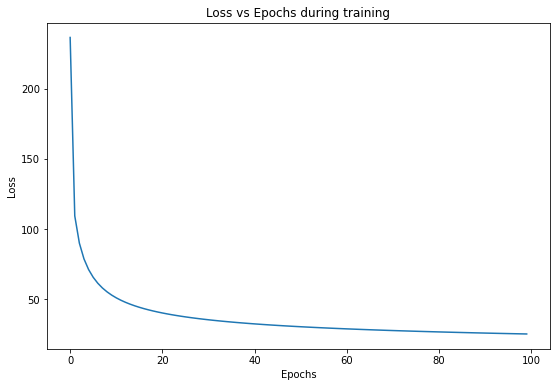

In [91]:
### Your code here
model = LogisticRegression(alpha = 0, t = 100, eta = 1e-3)
tr_loss = model.train(cancer_X_train, cancer_y_train)
plt.figure(figsize=(9, 6))
plt.plot(tr_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs during training")
plt.show()

**Use your trained model to make predictions and report the accuracy on the training, validation, and test sets. Report the first 5 predictions on the test set, along with the actual labels.** Your accuracies should be much higher than the baseline accuracy we found in Section 2.1.

In [92]:
### Your code here

predictions_train = model.predict(cancer_X_train)
count = 0
for idx, value in enumerate(cancer_y_train):
    if predictions_train[idx]==cancer_y_train[idx]:
        count+=1
print("Classification Accuracy (Training set):", count/len(cancer_y_train)*100)

predictions_val = model.predict(cancer_X_val)
count = 0
for idx, value in enumerate(cancer_y_val):
    if predictions_val[idx]==cancer_y_val[idx]:
        count+=1
print("Classification Accuracy (Validation set):", count/len(cancer_y_val)*100)

predictions_test = model.predict(cancer_X_test)
count = 0
for idx, value in enumerate(cancer_y_test):
    if predictions_test[idx]==cancer_y_test[idx]:
        count+=1
print("Classification Accuracy (Test set):", count/len(cancer_y_test)*100)

print("First 5 predictions on Test set: ", predictions_test[:5])
print("First 5 actual labels in Test set: ", cancer_y_test[:5])

Classification Accuracy (Training set): 98.82697947214076
Classification Accuracy (Validation set): 96.49122807017544
Classification Accuracy (Test set): 95.6140350877193
First 5 predictions on Test set:  [1. 0. 0. 0. 0.]
First 5 actual labels in Test set:  [1 0 0 0 0]


**Interpret your trained model using a bar chart of the model weights.** Make sure to label the bars (x-axis) and don't forget the bias term! Use lecture 3, slide 15 as a reference.

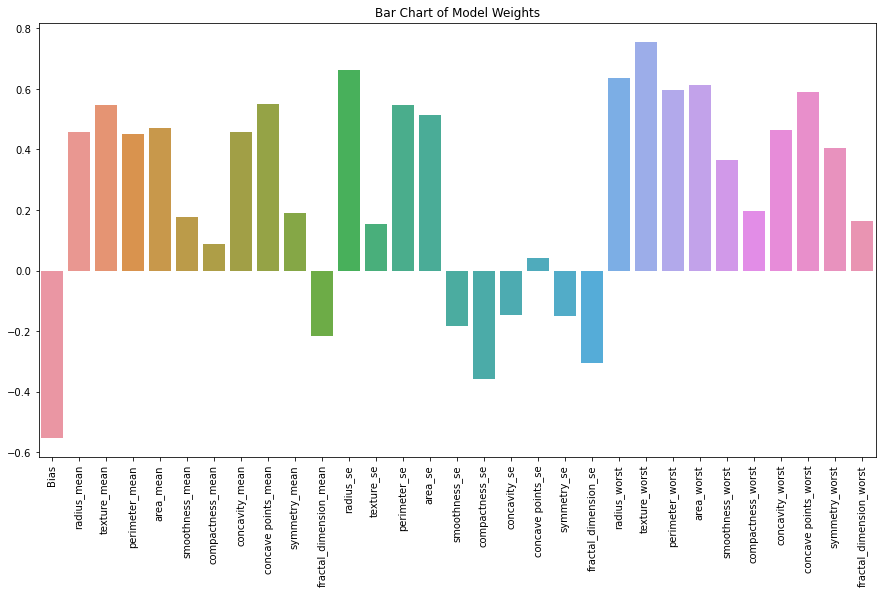

In [94]:
### Your code here
plt.figure(figsize = (15,8))
plt.title("Bar Chart of Model Weights")
sns.barplot(x = ['Bias'] + list(X_dev.columns), y = model.w)
plt.xticks(rotation = 90)
plt.show()

**According to your model, which features are the greatest contributors to the diagnosis?**

### Your answer here

The top 3 most important features are texture_worst, radius_se and radius_worst. All features other than concave points_se, compactness_mean, smoothness_mean, symmetry_mean, texture_se, smoothness_se, concavity_se and symmetry_se are important contributors to the diagnosis. This is evident from the graph above.

### 2.5 Tune Regularization Parameter  𝛼

Now, we will observe the effect of tuning the regularization parameter $\alpha$ on the learned weights of the model.

**Sweep out values for $\alpha$ using `alphas = np.logspace(-2, 2, 100)`. For each $\alpha$ value, train a logistic regression model and record its weights. Plot the weights for each feature as a function of $\alpha$ on a single figure. Make sure to label the axes.** You should have 31 curves (one for each feature) in the plot.

In [95]:
### Your code here
alphas=np.logspace(-2,2,100)
weights=[]
for alpha in alphas:
    model = LogisticRegression(alpha = alpha, t = 100, eta = 1e-3)
    tr_loss = model.train(cancer_X_train, cancer_y_train)
    weights.append(model.w.tolist())

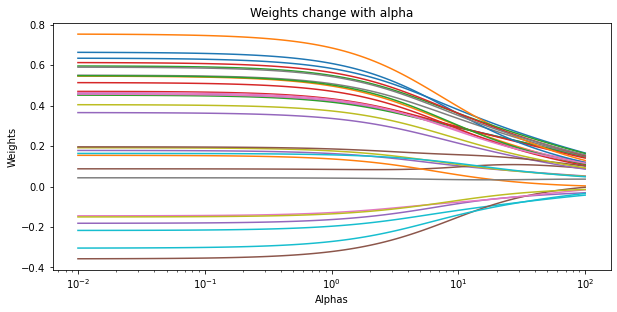

In [96]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1)
def Extract(lst,num):
    return [item[num] for item in lst]
for i in range(1,31): 
    y=Extract(weights,i)
    ax.plot(alphas,y)
ax.set_xscale('log')
ax.set_xlabel('Alphas')
ax.set_ylabel('Weights')
ax.set_title('Weights change with alpha')
plt.show()

**Describe the effect of the regularization parameter $\alpha$ on the weights of your model. Please explain in terms of model complexity.**

### Your answer here

The model complexity falls with an increase in alpha. This can be seen as all weights begin to converge to near 0. This often reduces overfitting but an alpha value too high will lead to underfitting.

## Part 3: SVM

You are allowed to use sklearn or any ML library in this part.

### 3.1 Train Primal SVM

**Train a primal SVM (with default parameters) on the breast cancer training data. Make predictions and report the accuracy on the training, validation, and test sets.**

In [99]:
### Your code here
from sklearn import svm
from sklearn import metrics
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(svm.LinearSVC(dual=False))
cancer_X_train=np.concatenate((cancer_X_train,cancer_X_val))
cancer_y_train=np.concatenate((cancer_y_train,cancer_y_val))
pipe.fit(cancer_X_train,cancer_y_train)
y_pred_test = pipe.predict(cancer_X_test)
y_pred_train = pipe.predict(cancer_X_train)
y_pred_val = pipe.predict(cancer_X_val)
print("Accuracy:",metrics.accuracy_score(cancer_y_train, y_pred_train)*100)
print("Accuracy:",metrics.accuracy_score(cancer_y_val, y_pred_val)*100)
print("Accuracy:",metrics.accuracy_score(cancer_y_test, y_pred_test)*100)
y_pred_test[:5]

Accuracy: 98.59402460456941
Accuracy: 98.24561403508771
Accuracy: 95.6140350877193


array([1, 0, 0, 0, 0])

### 3.2 Train Dual SVM

**Train a dual SVM (with default parameters) on the breast cancer training data. Make predictions and report the accuracy on the training, validation, and test sets.**

In [101]:
### Your code here
pipe_dual = make_pipeline(svm.SVC(kernel='linear'))
pipe_dual.fit(cancer_X_train,cancer_y_train)
y_pred_test = pipe_dual.predict(cancer_X_test)
y_pred_train = pipe_dual.predict(cancer_X_train)
y_pred_val = pipe_dual.predict(cancer_X_val)
print("Train Accuracy:",metrics.accuracy_score(cancer_y_train, y_pred_train)*100)
print("Val Accuracy:",metrics.accuracy_score(cancer_y_val, y_pred_val)*100)
print("Test Accuracy:",metrics.accuracy_score(cancer_y_test, y_pred_test)*100)
y_pred_test[:5]

Train Accuracy: 98.59402460456941
Val Accuracy: 98.24561403508771
Test Accuracy: 97.36842105263158


array([1, 0, 0, 0, 0])

### 3.3 Number of Support Vectors

**Find the number of support vectors in your SVM model.**

In [102]:
### Your code here
print('Number of support vectors: ',pipe_dual[0].support_vectors_.shape[0])

Number of support vectors:  42


### 3.4 Hyperparameter Tuning

**Improve the SVM model (by hyperparameter tuning, feature selection, or using a non-linear SVM) to get better test performance than the dual SVM.**

In [104]:
### Your code here
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
param_grid={"C":np.logspace(-1,1,20),'gamma':np.logspace(-3,1,10)}
pipe = make_pipeline(GridSearchCV(svm.SVC(kernel='rbf'),param_grid ,return_train_score=True))
pipe.fit(cancer_X_train,cancer_y_train)
grid_search_results=pipe.named_steps['gridsearchcv']

In [105]:
grid_search_results.best_params_

{'C': 0.8858667904100825, 'gamma': 0.021544346900318832}

In [106]:
pipe.score(cancer_X_test, cancer_y_test)

0.9824561403508771